In [64]:
!pip install pillow -q
!pip install datasets -q
!pip install torch -q
!pip install torchvision -q
!pip install matplotlib -q
!pip install datasets -q
!pip install torchmetrics -q
!pip install timm -q

/home/user/.local/lib/python3.12/site-packages/deeplake/__init__.py:323: UserWarning: Global variable 'ds_test' of type <class 'deeplake._deeplake.DatasetView'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
  warnings.warn(
/home/user/.local/lib/python3.12/site-packages/deeplake/__init__.py:323: UserWarning: Global variable '_51' of type <class 'deeplake._deeplake.RowView'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
  warnings.warn(
/home/user/.local/lib/python3.12/site-packages/deeplake/__init__.py:323: UserWarning: Global variable '_54' of type <class 'deeplake._deeplake.ColumnView'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.4 requires dill>=0.4.0, but you have dill 0.3.8 which is incompatible.
pathos 0.3.4 requires multiprocess>=0.70.18, but you have multiprocess 0.70.16 which is incompatible.


In [1]:
from datasets import load_dataset
import PIL
import torch
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import timm
from timm.loss import SoftTargetCrossEntropy
import pickle
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

2025-05-19 21:12:38.149422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747689158.622958    1125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747689158.713010    1125 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 21:12:39.519200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Global

In [7]:
torch.backends.cudnn.benchmark = True

NUM_CLASSES = 200
BATCH_SIZE = 64  
NUM_EPOCHS = 10  
LEARNING_RATE = 1e-4  
WEIGHT_DECAY = 0.01  
IMAGE_SIZE = 384
LOG_INTERVAL = 100 
DATA_DIR = "data/"
MODEL_DIRS = DATA_DIR+"models/"
BASE_MODEL = MODEL_DIRS+"interpolated_vit_tiny_imagenet.pth"
TRAIN_DATA = DATA_DIR+"train.pkl"
VALID_DATA = DATA_DIR+"valid.pkl"

# Utils

In [8]:
class TorchDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform=transform

    def __repr__(self):
        return str(self.hf_dataset)

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        example = self.hf_dataset[idx]
        image = example['image']
        if self.transform:
            image =  self.transform(image)
        return image, example['label']

In [9]:
def gen_super_tiny(dataset, split, q=10, p=0, step=500, classes=200):
    from datasets import Dataset
    images_per_class = {"validation":50,
                       "test":50,
                       "train":500
                       }
    dataset_length = images_per_class[split]*classes
    t = [dataset[p+i:i+q] for i in range(0, dataset_length-q, step)]
    all_images = [image for image_class_dict in t for image in image_class_dict["image"]]
    all_labels = [image for image_class_dict in t for image in image_class_dict["label"]]
    return Dataset.from_dict({"image":all_images, "label":all_labels})

In [10]:
def print_patches(image_unfolded):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    visualize = v2.Compose([v2.ToPILImage(), v2.Resize((100,100))])
    if len(image_unfolded.shape) == 5:
        image_unfolded = image_unfolded[None,:,:,:,:,:]
    for i in range(image_unfolded.shape[0]):
        n_channels, n_patches_h, n_patches_w, h, w = image_unfolded.shape[1:]
        patches = image_unfolded[i].permute(1, 2, 0, 3, 4).reshape(-1, n_channels, h, w)
        for patch in patches:
            visualize(patch).show()

In [11]:
visualize = v2.Compose([v2.ToPILImage(), v2.Resize((100,100), antialias=False)])

# Data

Loading dataset

In [12]:
try:
    train_dataset = pickle.load(open(TRAIN_DATA,"rb"))
    valid_dataset = pickle.load(open(VALID_DATA,"rb"))
except:
    train_dataset = load_dataset('Maysee/tiny-imagenet', split='train')
    valid_dataset = load_dataset('Maysee/tiny-imagenet', split='valid')
    pickle.dump(train_dataset, open(TRAIN_DATA,"wb"))
    pickle.dump(valid_dataset, open(VALID_DATA,"wb"))

#### Data Augmentation and Transformations

In [13]:
transform_train = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomErasing(p=0.25),

])

transform_valid = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [14]:
train_loader = torch.utils.data.DataLoader(
    TorchDatasetWrapper(train_dataset, transform_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,  
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    TorchDatasetWrapper(valid_dataset, transform_valid),
    batch_size=3,
    shuffle=False,
    num_workers=2,  
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)
next(iter(val_loader))

[tensor([[[[ 2.0777,  2.1290,  2.1462,  ...,  2.2318,  2.2318,  2.2318],
           [ 2.1633,  2.1462,  2.1633,  ...,  2.2318,  2.2318,  2.2318],
           [ 2.1975,  2.1975,  2.1633,  ...,  2.2147,  2.2147,  2.2147],
           ...,
           [ 1.2728,  1.9578,  2.2318,  ...,  1.6838,  1.6667,  1.5982],
           [ 2.0434,  2.0777,  1.8037,  ...,  2.1462,  2.1119,  1.9920],
           [ 2.0092,  1.9407,  2.0263,  ...,  2.2318,  2.2318,  2.1975]],
 
          [[ 2.4111,  2.4111,  2.4286,  ...,  2.4111,  2.4111,  2.4111],
           [ 2.4286,  2.4286,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
           [ 2.4286,  2.4286,  2.4111,  ...,  2.3936,  2.3936,  2.3936],
           ...,
           [ 1.4482,  2.1485,  2.4286,  ...,  1.8508,  1.8333,  1.7633],
           [ 2.4286,  2.4286,  2.1835,  ...,  2.3235,  2.2885,  2.2185],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4111,  2.4111,  2.4286]],
 
          [[ 2.5703,  2.5877,  2.6051,  ...,  2.6226,  2.6226,  2.6226],
           [ 

In [15]:
# Mixup and CutMix
mixup_fn = timm.data.Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    prob=0.5,  # Reduced probability to allow some original images
    switch_prob=0.5,
    mode='batch',
    label_smoothing=0.1,
    num_classes=NUM_CLASSES
)

# Model

In [16]:
model = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=NUM_CLASSES)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/transforms/v2/functional/_geometry.py:309: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


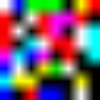

In [17]:
patch_kernels = model.patch_embed.proj.weight
interpooled_patch_embedding = torch.nn.functional.interpolate(patch_kernels, size=(8,8), mode="bicubic")
visualize(interpooled_patch_embedding[59]).show()

In [18]:
pos_embed = model.pos_embed
print(pos_embed.shape)
pos_embed = pos_embed.reshape(577, 768)
cls_pos_embedding, pos_embed = torch.split(pos_embed, [1, 576])
pos_embed = pos_embed.reshape(24, 24, 768).permute(2, 0, 1)
pos_embed.shape
pos_embed = torch.nn.functional.interpolate(pos_embed.unsqueeze(0), size=(8, 8), mode="bicubic")
pos_embed = pos_embed.reshape(1, 768, 64).permute(0, 2, 1)
print(pos_embed.shape)
pos_embed = torch.cat([pos_embed, cls_pos_embedding.unsqueeze(0)], dim=1)

torch.Size([1, 577, 768])
torch.Size([1, 64, 768])


In [19]:
model.pos_embed = torch.nn.Parameter(pos_embed)
model.patch_embed.proj = torch.nn.Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
model.patch_embed.proj.weight = torch.nn.Parameter(interpooled_patch_embedding)
model.img_size = 64
model.patch_embed.img_size = (64, 64)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [21]:
device.type

'cuda'

In [22]:
model.load_state_dict(torch.load(BASE_MODEL, weights_only=True, map_location=device))

<All keys matched successfully>

In [23]:
model.eval()
for param in model.parameters():
    param.requires_grad = False

Evaluation of model performances

In [49]:
import time
def benchmark_model(model, device, gpu=True, cpu=False, WARMUPS=10, batch_sizes=[1,2,4,8,16,32,64], n_iters=[50,25,10,10,10,10,10], acc=True, cpu_acc=False):
    def test_accuracy(model, device, WARMUPS=10, batch_sizes=[1,2,4,8,16,32,64], n_iters=[50,25,10,10,10,10,10], acc=True, cpu_acc=False):
        if not cpu_acc and device.type == "cpu":
            raise AssertionError("Set cpu_acc=True if you want to check accuracy with cpu, otherwise set acc=False to skip accuracy benchmark")
        model.to(device)
        test_loader = torch.utils.data.DataLoader(
            TorchDatasetWrapper(valid_dataset, transform_valid),
            batch_size=max(batch_sizes),
            shuffle=False,
            num_workers=2,  
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        test_loader_tqdm = tqdm(test_loader, desc=f"Testing Accuracy")
        total=0
        correct=0
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            batch_correct = predicted.eq(labels).sum().item()
            correct += batch_correct
            total += len(labels)
        return correct/total

    def test_gpu_speed(model, device, WARMUPS=10, batch_sizes=[1,2,4,8,16,32,64], n_iters=[50,25,10,10,10,10,10], acc=True, cpu_acc=False):
        print("Benchmarking GPU")
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        results = []
        model.to(device)
        for batch_size,  n_iter in zip(batch_sizes, n_iters):
            test_loader = torch.utils.data.DataLoader(
                TorchDatasetWrapper(valid_dataset, transform_valid),
                batch_size=batch_size,
                shuffle=False,
                num_workers=2,  
                pin_memory=True,
                prefetch_factor=4,
                persistent_workers=True
            )
            
            images, labels = next(iter(test_loader))
            images, labels = images.to(device), labels.to(device)
            for _ in range(WARMUPS):
                _ = model(images)
            print(f"Benchmarking batch size {batch_size}")
            torch.cuda.synchronize()
            start_event.record()
            with torch.no_grad():
                for _ in range(n_iter):
                    _ = model(images)
            end_event.record()
            torch.cuda.synchronize() 
            elapsed = start_event.elapsed_time(end_event) / 100
            avg_time_per_batch = elapsed / n_iter * 1000  # ms per batch
            avg_time_per_image = avg_time_per_batch / batch_size   # ms per image
            throughput = 1000 / avg_time_per_image         # images/second
            batch_result = {"bs":batch_size, "mode":"gpu",}
            batch_result["values"] = {
                "time_per_batch_ms": avg_time_per_batch,
                "time_per_image_ms": avg_time_per_image,
                "throughput_imgs/s": throughput
            }
            results.append(batch_result)
        return results
            
    def test_cpu_speed(model, device, WARMUPS=10, batch_sizes=[1,2,4,8,16,32,64], n_iters=[64,32,16,8,4,2,1], acc=True, cpu_acc=False):
        print("Benchmarking CPU")
        results = []
        model = model.to(torch.device("cpu"))
        for batch_size,  n_iter in zip(batch_sizes, n_iters):
            test_loader = torch.utils.data.DataLoader(
                TorchDatasetWrapper(valid_dataset, transform_valid),
                batch_size=batch_size,
                shuffle=False,
                num_workers=2,  
                pin_memory=False,
                persistent_workers=False
            )
            images, labels = next(iter(test_loader))
            for _ in range(WARMUPS):
                _ = model(images)
            print(f"Benchmarking batch size {batch_size}")
            start_time = time.time()
            with torch.no_grad():
                for _ in range(n_iter):
                    _ = model(images)
            elapsed = time.time() - start_time
            avg_time_per_batch = elapsed / n_iter * 1000  # ms per batch
            avg_time_per_image = avg_time_per_batch / batch_size   # ms per image
            throughput = 1000 / avg_time_per_image         # images/second
            batch_result = {"bs":batch_size, "mode":"cpu",}
            batch_result["values"] = {
                "time_per_batch_ms": avg_time_per_batch,
                "time_per_image_ms": avg_time_per_image,
                "throughput_imgs/s": throughput
            }
            results.append(batch_result)
        return results

        def process_results(results_gpu, results_cpu):
            results = []
            if results_gpu and results_cpu: 
                results_zipped = zip(results_gpu, results_cpu)
            elif results_gpu:
                results_zipped = zip(results_gpu, [[]]*len(results_gpu))
            elif results_cpu:
                results_zipped = zip(results_cpu, [[]]*len(results_gpu))
        
            for result_gpu, result_cpu in results_zipped:
                dic = []
                if result_gpu: 
                    batch_size = result_gpu.pop("bs")
                    dic.append(result_gpu)
                if result_cpu: 
                    batch_size = result_cpu.pop("bs")
                    dic.append(result_cpu)
                results.append({"batch_size":batch_size,
                               "value":dic
                               })
            return results
        
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    if acc:
        accuracy = test_accuracy(model, device, WARMUPS, batch_sizes, n_iters, acc, cpu_acc)
    if gpu:
        results_gpu = test_gpu_speed(model, device, WARMUPS, batch_sizes, n_iters, acc, cpu_acc)
    if cpu:
        results_cpu = test_cpu_speed(model, device, WARMUPS, batch_sizes, [64,32,16,8,4,2,1], acc, cpu_acc)
    return process_results(results_gpu, results_cpu), accuracy

benchmark, accuracy = benchmark_model(model, device, gpu=True, cpu=True)

Testing Accuracy: 100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.27it/s]

Benchmarking GPU


Benchmarking batch size 1
Benchmarking batch size 2
Benchmarking batch size 4
Benchmarking batch size 8
Benchmarking batch size 16
Benchmarking batch size 32
Benchmarking batch size 64
Benchmarking CPU
Benchmarking batch size 1
Benchmarking batch size 2
Benchmarking batch size 4
Benchmarking batch size 8
Benchmarking batch size 16
Benchmarking batch size 32
Benchmarking batch size 64
